In [1]:
import numpy as np
from pandas import read_csv

## Read data from URL.
url = 'https://raw.githubusercontent.com/szorowi1/qmss2017/master/module3/random/random.csv'
data = read_csv(url)
data.head(3)

,y,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10
0,tango,-5.738806,7.903669,3.322340,-0.454518,16.532828,0.108963,1.409807,-1.245656,8.429060,-9.485051
1,tango,-2.924918,4.776924,3.979680,-1.592813,10.070496,0.447814,-1.497565,0.741973,5.404957,-11.145451
2,foxtrot,-7.371013,6.783924,3.154825,-2.325751,16.109512,0.103180,0.508613,-1.168624,9.025390,-12.657244


In [2]:
data = data.set_index('y')
data.head(3)

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10
y,,,,,,,,,,
tango,-5.738806,7.903669,3.322340,-0.454518,16.532828,0.108963,1.409807,-1.245656,8.429060,-9.485051
tango,-2.924918,4.776924,3.979680,-1.592813,10.070496,0.447814,-1.497565,0.741973,5.404957,-11.145451
foxtrot,-7.371013,6.783924,3.154825,-2.325751,16.109512,0.103180,0.508613,-1.168624,9.025390,-12.657244


In [3]:
data.loc['hotel'].head(5)

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10
y,,,,,,,,,,
hotel,-2.148849,8.209149,1.716670,-2.057981,8.346963,0.453410,-0.646912,0.990764,5.081341,-8.893599
hotel,-4.712117,12.246013,2.725242,-1.996836,9.278563,0.417651,-0.042003,-1.201154,8.530219,-10.561583
hotel,-5.610569,5.365686,2.373778,-1.945022,13.765744,0.209197,0.968587,-1.280130,9.260891,-8.820177
hotel,-5.317170,7.655662,3.141797,-1.541819,11.543820,0.374327,-1.071597,-1.939248,10.010425,-12.543524
hotel,-0.944963,7.944996,1.465616,-1.711348,14.272865,0.648101,0.930239,-1.573197,9.741746,-9.315313


# Scikit-Learn Tutorial

## Data Coding

In [4]:
data.describe().round(3)

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10
count,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000
mean,-5.891,7.529,2.308,-1.696,14.056,0.344,0.180,-1.144,9.118,-10.725
std,2.844,1.713,1.446,0.774,3.186,0.205,1.388,1.143,2.134,2.023
min,-12.369,2.556,-2.724,-3.745,3.924,-0.250,-3.028,-3.837,4.234,-16.374
25%,-7.848,6.399,1.417,-2.230,11.950,0.209,-0.745,-2.021,7.583,-12.015
50%,-5.843,7.577,2.360,-1.637,13.769,0.362,0.206,-1.246,9.175,-10.644
75%,-3.825,8.756,3.168,-1.184,16.112,0.471,1.237,-0.322,10.623,-9.386
max,3.861,13.242,5.982,0.216,23.396,0.910,3.718,2.099,14.949,-5.868


### Dummy Coding

In [5]:
from pandas import get_dummies

## Make dummy coded variables.
get_dummies(data.index).head(10)

,foxtrot,hotel,tango,yankee
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,1,0,0,0
4,0,0,0,1
5,0,0,1,0
6,1,0,0,0
7,0,1,0,0
8,1,0,0,0
9,0,0,1,0


### Digitizing

In [6]:
## Define bins.
bins = [-9,-7,-5,-3,-1]

x = data.x01
xd = np.digitize(x, bins)

for a,b in np.c_[x,xd][::20]:
    print('%0.3f\t%0.0f' %(a,b))

-5.739	2
-5.317	2
-7.521	1
-3.429	3
-10.959	0
-9.192	0
-1.550	4
-7.833	1
-4.926	3
-10.388	0


### Data Scaling
Scikit-Learn includes several built-in preprocessing algorithms for transforming/recoding data:
* **StandardScaler:** scales a variable such that it is mean = 0, sd = 1
* **RobustScaler:** scales a variable using medians and quartiles (i.e. 25% of data falls beneath 1st quartile)
* **MinMaxScaler:** scales a variable between a specified min and max (e.g. [0,1])
* **Normalizer:** scales each data point such that the feature vector has a euclidean length of one

We will test two of these now, applying the RobustScaler to all continous data and the MinMaxScaler to all nominal data.

In [7]:
from sklearn.preprocessing import StandardScaler

## Apply standard-score (z-score) transform to data. 
data.loc[:,:] = StandardScaler().fit_transform(data.loc[:,:])

data.describe().round(3)

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10
count,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000,200.000
mean,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000
std,1.003,1.003,1.003,1.003,1.003,1.003,1.003,1.003,1.003,1.003
min,-2.283,-2.910,-3.487,-2.654,-3.188,-2.902,-2.318,-2.363,-2.295,-2.800
25%,-0.690,-0.661,-0.617,-0.691,-0.662,-0.660,-0.669,-0.769,-0.721,-0.639
50%,0.017,0.028,0.036,0.077,-0.090,0.086,0.019,-0.090,0.027,0.040
75%,0.728,0.718,0.597,0.664,0.647,0.622,0.763,0.721,0.707,0.663
max,3.438,3.343,2.547,2.479,2.939,2.768,2.556,2.845,2.740,2.407


## Feature Selection & Dimensionality Reduction

### Variance Inflation Factor

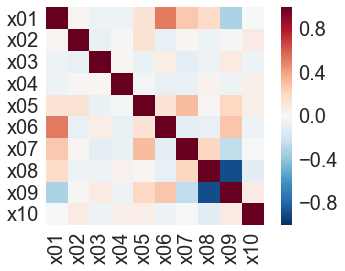

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

sns.heatmap(data.corr(), vmin=-1, vmax=1, square=True);

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variance_inflation_factor?

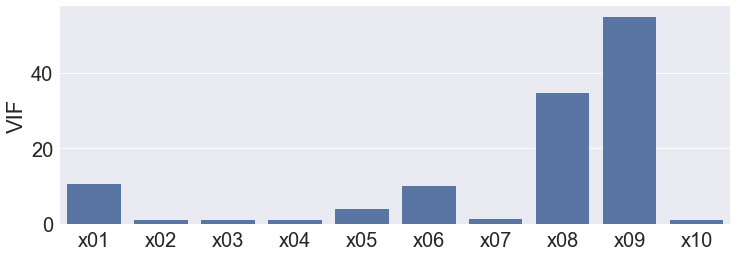

In [10]:
## Compute VIF.
VIF = [variance_inflation_factor(data.as_matrix(), n) for n in range(data.shape[-1])]

## Plot.
fig = plt.figure(figsize=(12,4))
color, = sns.color_palette(n_colors=1)
ax = sns.barplot(np.arange(data.shape[-1]), VIF, color=color);
ax.set(xticklabels=data.columns,  ylabel='VIF');

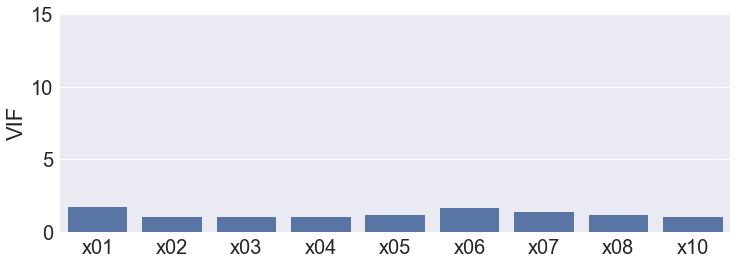

In [11]:
## Drop column x09.
data = data.drop('x09', axis=1)

## Compute VIF.
VIF = [variance_inflation_factor(data.as_matrix(), n) for n in range(data.shape[-1])]

## Plot.
fig = plt.figure(figsize=(12,4))
color, = sns.color_palette(n_colors=1)
ax = sns.barplot(np.arange(data.shape[-1]), VIF, color=color);
ax.set(xticklabels=data.columns, ylim=(0,15), ylabel='VIF');

### Feature Selection
Scikit-Learn also includes a number of featuers for the automatic reduction of features to those most explanatorily useful. These include:
* **Univariate approches:** selection of features with statistically significant relationships to the target. These approaches only consider each feature individually. Consequently a feature will be discarded if it is only informative when combined with another feature. 
* **Model-based approaches:** use a supervised machine learning model to judge the importance of each feature, and keeps only the most important ones. The supervised model that is used for feature selection doesn’t need to be the same model that is used for the final supervised modeling.
* **Iterative selection:** a series of models is built, with varying numbers of features. There are two basic methods: starting with no features and adding features one by one, until some stopping criterion is reached, or starting with all features and removing features one by one, until some stopping criterion is reached. 

Model-based and iterative selection methods are more complicated, powerful approaches. For now, we will demonstrate feature selection with the simpler univariate approaches. There are several functions to choose from including **SelectKBest**, **SelectPercentile**, **SelectFdr**, and **SelectFwe**. As the names imply, the first two functions select the K-best and N%-best features, whereas the latter two select features that are statistically significant after multiple comparisons corrections.

With 271 observations and 159 features, the phenotype dataset could stand to use a little more pruning.

In [12]:
from sklearn.feature_selection import SelectPercentile, SelectFdr, SelectFwe

## Initialize feature selection classes.
fwe = SelectFwe(alpha=0.05)

## Fit to data.
fit = fwe.fit(data, data.index)

## Find surviving columns.
fwe_cols = fit.get_support()
fwe_cols

array([ True, False, False, False,  True, False,  True,  True, False], dtype=bool)

Scikit-Learn attributes can be chained.

In [13]:
fwe_cols = SelectFwe(alpha=0.05).fit(data,data.index).get_support()
fwe_cols

array([ True, False, False, False,  True, False,  True,  True, False], dtype=bool)

Reduce data to surviving columns.

In [14]:
data = data[data.columns[fwe_cols]]
data.head(5)

,x01,x05,x07,x08
y,,,,
tango,0.053694,0.779390,0.888375,-0.089157
tango,1.045594,-1.254035,-1.212208,1.654749
foxtrot,-0.521661,0.646190,0.237260,-0.021570
foxtrot,-1.367967,-0.135196,0.608270,0.938623
yankee,-1.191913,0.451086,-1.101119,-1.008862


## Unsupervised Learning

In [15]:
from sklearn.decomposition import PCA

## Initialize with desired number of components.
pca = PCA(n_components=2)

## Fit to data.
fit = pca.fit(data)
print(fit.explained_variance_ratio_)

## Transform.
data_2d = fit.transform(data)
print(data_2d.shape)

[ 0.39692612  0.25151459]
(200, 2)


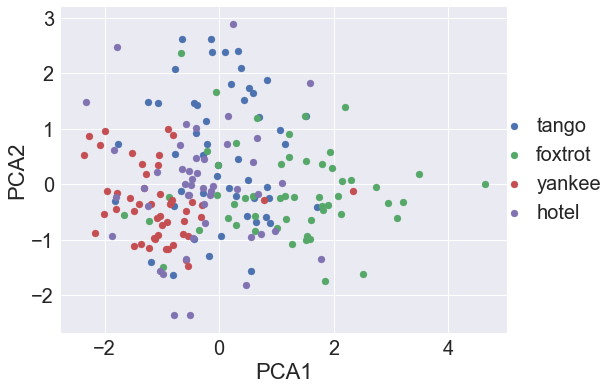

In [16]:
from pandas import DataFrame

## Fit into DataFrame.
data_2d = DataFrame(fit.transform(data), columns=('PCA1','PCA2'), index=data.index)

## Plot.
y_types = data_2d.index.unique()
colors = sns.color_palette(n_colors=len(y_types))

fig, ax = plt.subplots(1,1,figsize=(8,6))
for y, color in zip(y_types, colors):
    ax.scatter(data_2d.loc[y, 'PCA1'], data_2d.loc[y, 'PCA2'], color=color, label=y)
ax.set(xlabel='PCA1', ylabel='PCA2')
ax.legend(loc=7, bbox_to_anchor=(1.25,0.5), handletextpad=0.1);

## Supervised Learning

### Train and Test Sets
Scikit-learn contains a function, **train_test_split**, that shuffles the dataset and splits it for you. This is perhaps the most essential function in all of Scikit-Learn. Fortunately it handles Pandas arrays making it easily compatible with any data that can be read into Python via Pandas. We demonstrate this function below on the diabetes dataset.

In [17]:
from sklearn.model_selection import train_test_split

## Separate out precictors and outcomes.
X = data.as_matrix()
y = data.index

## Split our dataset into four variables using train_test_split.
## We hold out 20% of the data for prediction. All but the last
## column are predictors.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.2, random_state=0)

print('Original data shape: (%s, %s)' %data.shape)
print('Train data shape: (%s, %s)' %X_train.shape)
print('Test data shape: (%s, %s)' %X_test.shape)

Original data shape: (200, 4)
Train data shape: (160, 4)
Test data shape: (40, 4)


### Fitting Models

In [18]:
from sklearn.svm import LinearSVC

## Initialize SVC with desired parameteres.
svc = LinearSVC(penalty='l2', C=1.0, random_state=0)

## Fit to data.
fit = svc.fit(X_train, y_train)

## Compute predictive accuracy to test data.
print('Training performance: %0.3f' %fit.score(X_train, y_train))
print('Test performance: %0.3f' %fit.score(X_test, y_test))

## Show predictions.
predictions = fit.predict(X_test)
predictions

Training performance: 0.762
Test performance: 0.575


array(['tango', 'yankee', 'hotel', 'yankee', 'foxtrot', 'hotel', 'hotel',
       'yankee', 'foxtrot', 'hotel', 'hotel', 'yankee', 'yankee', 'tango',
       'yankee', 'tango', 'yankee', 'foxtrot', 'foxtrot', 'tango',
       'yankee', 'foxtrot', 'yankee', 'yankee', 'foxtrot', 'yankee',
       'tango', 'foxtrot', 'foxtrot', 'yankee', 'yankee', 'hotel',
       'yankee', 'foxtrot', 'hotel', 'foxtrot', 'foxtrot', 'yankee',
       'yankee', 'yankee'], dtype=object)

In [19]:
from sklearn.metrics import confusion_matrix

confmat = DataFrame(confusion_matrix(y_test, predictions), columns=np.unique(y_test), 
                    index=np.unique(y_test))
confmat = confmat.apply(lambda x: x / x.sum(), 1)

confmat.round(3)

,foxtrot,hotel,tango,yankee
foxtrot,0.714,0.000,0.000,0.286
hotel,0.200,0.400,0.200,0.200
tango,0.444,0.222,0.222,0.111
yankee,0.000,0.071,0.071,0.857


### Cross-Validation
One downside to train_test_split is that it splits the data only once. This can be problematic as that one model fit may be unrepresentative of the underlying true model fit as a result of the random allocation of data to the train/test sets. Thus, it is better to test models on multiple sets of the data. Fortunately, Scikit-Learn has many [built-in functions](http://scikit-learn.org/stable/modules/cross_validation.html) for sampling and resampling train/test sets:
* **K-fold:** divides all the samples in k groups of samples, called folds of equal sizes (if possible). The prediction function is learned using k - 1 folds, and the fold left out is used for test.
* **Leave One Out (LOO):** each learning set is created by taking all the samples except one, the test set being the sample left out. This cross-validation procedure does not waste much data as only one sample is removed from the training set.
* **Leave P Out (LPO):** very similar to LeaveOneOut as it creates all the possible training/test sets by removing p samples from the complete set.
* **Shuffle & Split:** generate a user defined number of independent train / test dataset splits. Samples are first shuffled and then split into a pair of train and test sets.
* **Stratified k-fold:** variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.
* **Stratified Shuffle & Split:**  variation of ShuffleSplit, which returns stratified splits, i.e which creates splits by preserving the same percentage for each target class as in the complete set.

We demonstrate two of these functions below.

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
StratifiedShuffleSplit?

In [21]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for train_ix, test_ix in sss.split(X, y):
    print(train_ix.shape, test_ix.shape)
    
print(train_ix[:10])
print(test_ix[:10])

(160,) (40,)
(160,) (40,)
(160,) (40,)
(160,) (40,)
(160,) (40,)
[199  14 169  47 143 147 188 197 133  57]
[ 77 195 101 158 178  33  51 185  93 131]


In [30]:
## Define train sizes.
train_sizes = np.linspace(0.2,0.8,13)
n_train_sizes = train_sizes.shape[0]
n_splits = 10
test_size = 0.2

## Preallocate space for performance data.
performance = np.zeros((n_train_sizes,n_splits,3))

## Iteratively compute scores.
for i, train_size in enumerate(train_sizes):
    
    ## Initialize cross-validation tool.
    sss = StratifiedShuffleSplit(n_splits=n_splits, train_size=train_size, 
                                 test_size=test_size, random_state=0)
    
    for j, indices in enumerate(sss.split(X,y)):
        
        ## Extract indices.
        train_ix, test_ix = indices
        
        ## Fit SVC.
        fit = svc.fit(X[train_ix], y[train_ix])
        
        ## Compute performance scores.
        train_score = fit.score(X[train_ix], y[train_ix])
        test_score = fit.score(X[test_ix], y[test_ix])
        
        ## Store information.
        performance[i,j,0] = train_size
        performance[i,j,1] = train_score
        performance[i,j,2] = test_score

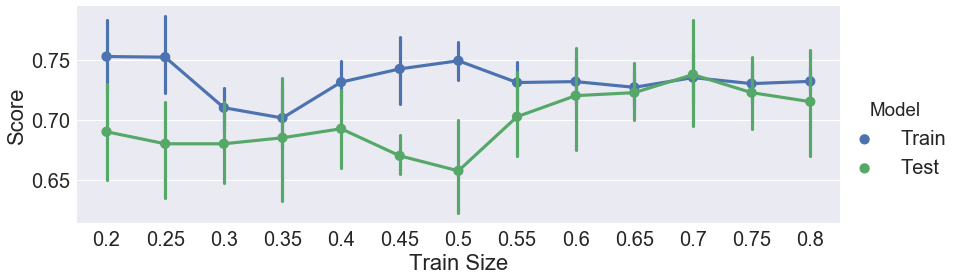

In [36]:
## Convert to DataFrame.
performance = DataFrame(performance.reshape(n_train_sizes*n_splits,3), 
                        columns=('Train Size','Train', 'Test'))

## Melt into longlist.
performance = performance.melt(id_vars='Train Size', var_name='Model', value_name='Score')

## Plot.
sns.factorplot('Train Size', 'Score', 'Model', data=performance, aspect=3);

In [37]:
from sklearn.model_selection import cross_val_score
cross_val_score?

In [ ]:
## Define parameters.
C_params = np.power( 10., [-2, -1, 0, 1, 2] )
n_c_params = C_params.shape[0]
kfold = 10

## Preallocate space for performance data.
performance = np.zeros((n_c_params,kfold,2))

for i, C in enumerate(C_params):
    
    ## Initialize SVC.
    svc = LinearSVC(penalty='l2', C=C, random_state=0)
    
    ## Perform cross-validation.
    scores = cross_val_score(svc, X, y, cv=kfold)
    
    ## Store.
    performance[i,:,0] = C
    performance[i,:,1] = scores

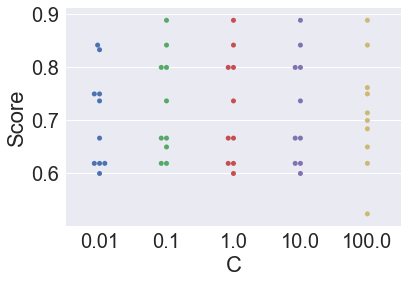

In [41]:
## Convert to DataFrame.
performance = DataFrame(performance.reshape(n_c_params*kfold,2), columns=('C','Score'))

## Plot.
sns.swarmplot('C','Score',data=performance);